# Formatting `CodonVariantTable` plots
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) generates informative plots about a deep mutational scanning experiment.
Here are some tips on how to format those plots.

## Setup for notebook

Import Python modules / packages:

In [1]:
import random
import tempfile
import warnings

from IPython.display import display, Image

from plotnine import *

import scipy

import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Hide warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

## Simulate a `CodonVariantTable`
We simulate a [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) to use to demonstrate the plot formatting.
Set parameters that define the simulated data:

In [3]:
seed = 1  # random number seed
genelength = 40  # gene length in codons
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.01  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 100,
        }

Seed random number generator for reproducible output:

In [4]:
random.seed(seed)

Simulate wildtype gene sequence:

In [5]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 40 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGT


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function:

In [6]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Simulate counts for samples.
First, we need a "phenotype" function to simulate the counts for each variant.
We define this function using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator):

In [7]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                            geneseq,
                                            seed=seed)

We then use the simulator to simulate some sample counts:

In [8]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib *
                        scipy.random.poisson(avgdepth_per_variant),
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={name: {'noise': noise,
                             'total_count': variants_per_lib *
                                 scipy.random.poisson(avgdepth_per_variant),
                             'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
        seed=seed,
        )

Add these counts to the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [9]:
variants.add_sample_counts_df(counts)

Now we've completed the simulation of the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

## Formatting plots
The plots returned by a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
above are all [plotnine](https://plotnine.readthedocs.io) ggplot objects.
So you
can format them differently by setting a [plotnine
theme](https://plotnine.readthedocs.io/en/stable/api.html#themes).

First make a plot using the default [plotnine](https://plotnine.readthedocs.io) theme:

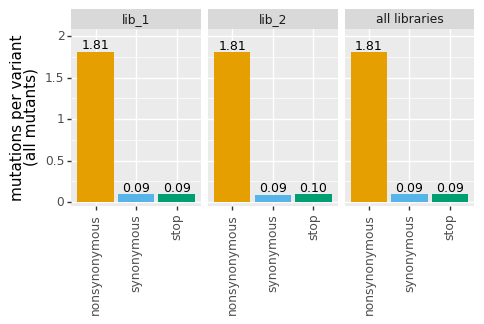

In [10]:
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

The `dms_variants` package defines a gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) that gives an especially nice appearance for the plots.
Here we set that theme and then re-draw the above plot:

In [11]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

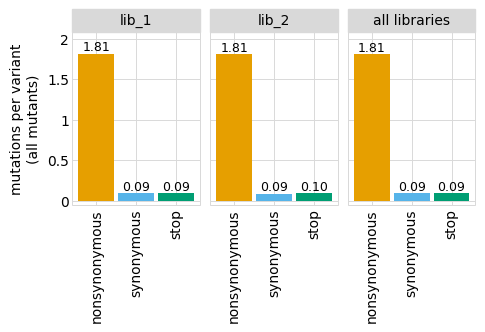

In [12]:
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

The plot looks even cleaner if we get rid of the vertical grid lines:

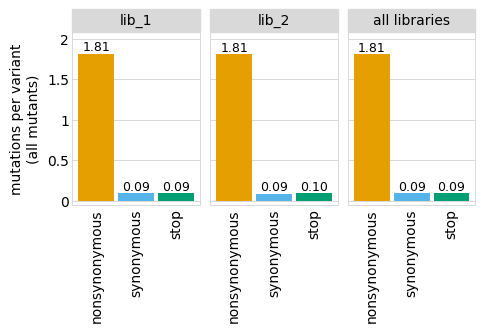

In [13]:
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

There are also lots of [other themes defined by plotnine](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes):

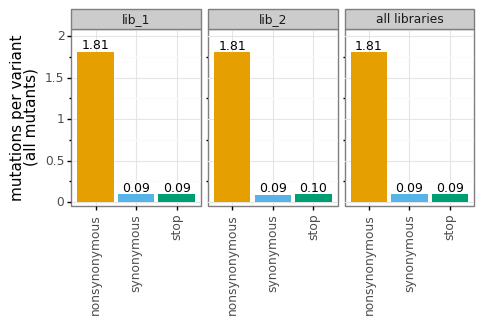

In [14]:
theme_set(theme_bw())
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Or more silly:

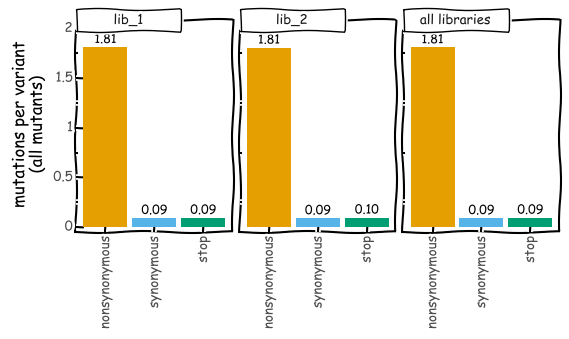

In [15]:
theme_set(theme_xkcd())
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    heightscale=1.2,
                                    widthscale=1.2)
_ = p.draw()

Note how the above call also used the `heightscale` and `widthscale` options
(which exist for all plotting methods of a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable))
to make the plot larger.

You can also set the orientation differently with
`orientation`, and rename samples with `sample_rename`:

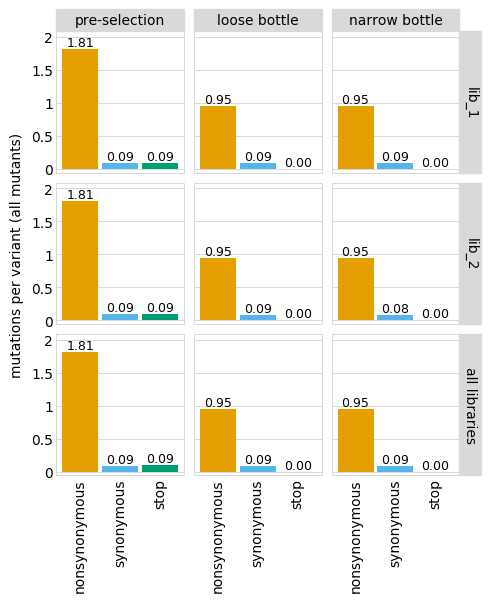

In [16]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())  # restore gray-grid theme

p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    orientation='v',
                                    heightscale=1.2,
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Or only show some of the facets.
For instance, just show the individual
libraries:

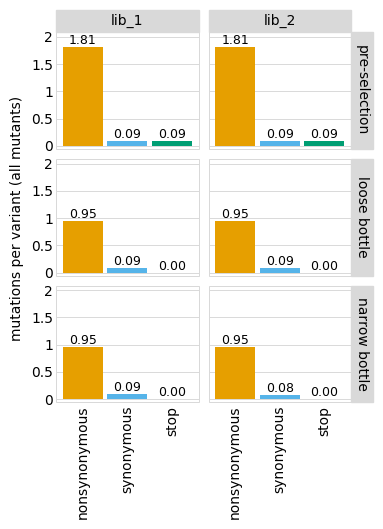

In [17]:
p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    libraries=variants.libraries,
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()


Or only the merge of all libraries:

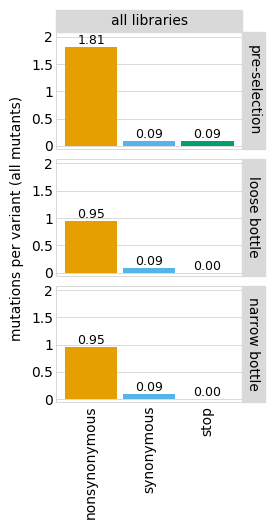

In [18]:
p = variants.plotNumCodonMutsByType('all',
                                    samples='all',
                                    libraries='all_only',
                                    sample_rename={'loose_bottle': 'loose bottle',
                                                   'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Or only show some samples:

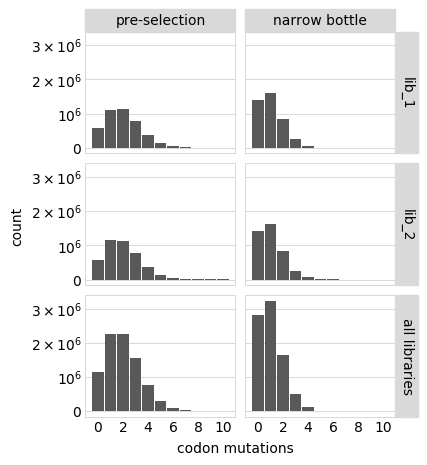

In [19]:
p = variants.plotNumMutsHistogram(mut_type='codon',
                                  samples=['pre-selection', 'tight_bottle'],
                                  orientation='v',
                                  sample_rename={'loose_bottle': 'loose bottle',
                                                 'tight_bottle': 'narrow bottle'})
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

You can also save the plots to image files using their `save` method.
Here we
show how to do this, saving the plot as a PNG to a temporary file and then
displaying that PNG:

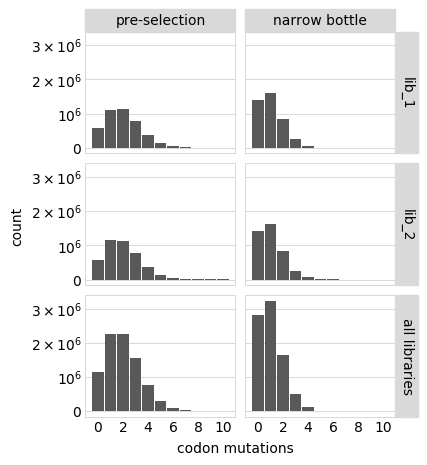

In [20]:
with tempfile.NamedTemporaryFile(suffix='.png') as f:
    p.save(f.name)
    display(Image(f.name))